## Grey Wolf Optimizer (GWO)

### Theory

The Grey Wolf Optimizer(GWO), proposed by Mirjalili et al. (2014), is a metaheuristic inspired by the social behavior of grey wolves. GWO simulates the pack hierarchy and the hunting strategies of wolves to perform function optimization.
GWO operates iteratively. First, an initial population of wolves in randomly generated, and fthe fitness of each individual is calculated to estabilish the social hierarchy. At each iteration, wolves update their positions through the encircling and hunting phases, guided by the best leaders. The fitness values are recalculated, and the process is repeated until a stopping criterion is reached(in this case, a fixed number of iterations).
#### Social Hierarchy
The population is divided by four groups:
- **α (alpha)**: the wolf with the best know solution.
- **β (beta)**: the second-best solutuin.
- **δ (delta)**: the third-best solution.
- **ω (ômega)**: the rest of the population.

#### Encircling phase

The hunting process begins with the wolves estimating the prey's position(the global minimum of the objective function). Each wolf updates its position based on the modified vector distance between itself and the three leading wolves(α, β e δ). This update is governed by two control vectors $( \vec{A} $) and $( \vec{C} $):

$$
\vec{D} = \left| \vec{C} \cdot \vec{X}_p(t) - \vec{X}(t) \right|
$$

$$
\vec{X}(t+1) = \vec{X}_p(t) - \vec{A} \cdot \vec{D}
$$

Where:
- $( \vec{X}(t) $) is the curent position of the wolf.
- $( \vec{X}_p(t) $) is the estimated position of the prey(either alfa, beta ou delta).
- $( \vec{C} = 2 \cdot r_2 $), where $( r_2 $) is a random vector ∈ [0,1], that perturbs the prey's position and increases diversity.
- $( \vec{A} = 2a \cdot r_1 - a $), where $( a $) decreases from 2 to 0 over the iterations (promoting exploration at the begining and convergence towards the end), and $( r_1 $) is also random vector ∈ [0,1]. This vector $ \vec{A} $ controls the step size and direction of the wolf movement.

#### Hunting phase

Each omega wolf computes a new position based on the influence of three leaders. For each leader, the following position are calculated:
$$
\vec{X}_1 = \vec{X}_\alpha - \vec{A}_1 \cdot \vec{D}_\alpha
$$
$$
\vec{X}_2 = \vec{X}_\beta - \vec{A}_2 \cdot \vec{D}_\beta
$$
$$
\vec{X}_3 = \vec{X}_\delta - \vec{A}_3 \cdot \vec{D}_\delta
$$

The final position of the wolf is avarage of the three influences:

$$
\vec{X}(t+1) = \frac{\vec{X}_1 + \vec{X}_2 + \vec{X}_3}{3}
$$




### Algorithm
*Initialize the grey wolf population $X_i$ (i = 1, 2, ..., n)*  
*for each iteration t < max_iter*  
  *Evaluate the fitness of all wolves*  
  *Sort wolves and select $X_α$, $X_β$, $X_δ$ as the top 3*  
  *Compute parameter $a$ = 2 × (1 - t / max_iter)*  
  *for each wolf $X_i$ where $i$ ≥ 3*  
    *for each dimension $j$*  
      *Generate random values $r_1$ and $r_2$*  
      *Compute vectors A and C*  
      *Calculate influences $D_α$, $D_β$, $D_δ$*  
      *Compute $X_1$, $X_2$, $X_3$ based on α, β, and δ*  
      *Set new position as mean of ($X_1$, $X_2$, $X_3$)*  
    *Clip position to respect bounds*  
    *Update fitness of wolf $X_i$*  
*end for*  
*Return the best wolf $X_α$ and its fitness*


In [20]:
import numpy as np
import random
from typing import Callable, Tuple, List
import matplotlib.pyplot as plt

In [24]:
#objective function: sphere
def sphere(x: np.array) -> float:
    return np.sum(x**2)

In [70]:
def ackley(x: np.ndarray, a: float = 20, b: float = 0.2, c: float = 2 * np.pi) -> float:
    d = len(x)
    sum1 = np.sum(x ** 2)
    sum2 = np.sum(np.cos(c * x))

    term1 = -a * np.exp(-b * np.sqrt(sum1 / d))
    term2 = -np.exp(sum2 / d)

    return term1 + term2 + a + np.exp(1)
    

In [55]:
def rosen(x: np.ndarray) -> float:
    xi = x[:-1]
    xnext= x[1:]
    return np.sum(100*(xnext -xi**2)**2 + (xi-1)**2)
    

In [32]:
#initialize initial population:
def initialize_pop_wolv(nwolves: int, dim:int, bounds: Tuple[float, float]) -> np.ndarray:
    return np.random.uniform(bounds[0], bounds[1], size=(nwolves, dim)) #return a array 2d with the random positions of the wolves in the interval of the bounds

In [36]:
def gwo(fobj, dim: int, bounds: Tuple[float, float], n_wolves: int, max_iter: int) -> Tuple[np.ndarray, float, List[float]]:
    wolves = initialize_pop_wolv(n_wolves, dim, bounds)
    history= [] #to save the history of best fitness

    for t in range(max_iter):
        fitness=[]
        for w in wolves:
            fitness.append(fobj(w))
        fitness=np.array(fitness)
        # sort the wolves in the best fitness
        sorted_indices = np.argsort(fitness)
        alpha, beta, delta = wolves[sorted_indices[:3]]
        a = 2 * (1 - t / max_iter) #exploitation coefficient/convergence

        for i in range(3, n_wolves):
            new_pos = []
            for j in range(dim): #calculates a position for each dimension 
                r1, r2 = random.random(), random.random() #random vector to create random variation
                A = 2 * a * r1 - a #vector that controls the direction and distance of movement
                C = 2 * r2 vector that controls the perception of the prey's position
                # alpha influence
                D_alpha = abs(C * alpha[j] - wolves[i][j])
                X1 = alpha[j] - A * D_alpha

                # beta influence
                D_beta = abs(C * beta[j] - wolves[i][j])
                X2 = beta[j] - A * D_beta

                # delta influence
                D_delta = abs(C * delta[j] - wolves[i][j])
                X3 = delta[j] - A * D_delta

                # updates the position as an average of the three influences
                new_pos.append((X1 + X2 + X3) / 3.0)

            # ensures the new position is within the limits
            wolves[i] = np.clip(new_pos, bounds[0], bounds[1])
            fitness[i] = fobj(wolves[i])

        # updates the best fitness history
        history.append(fitness.min())

    best_index = np.argmin(fitness) #index of the min value of the fitness array
    return wolves[best_index], fitness[best_index], history


melhor posição encontrada: [4.44830509e-24 1.05896371e-23]
melhor valor (fitness): 4.440892098500626e-16


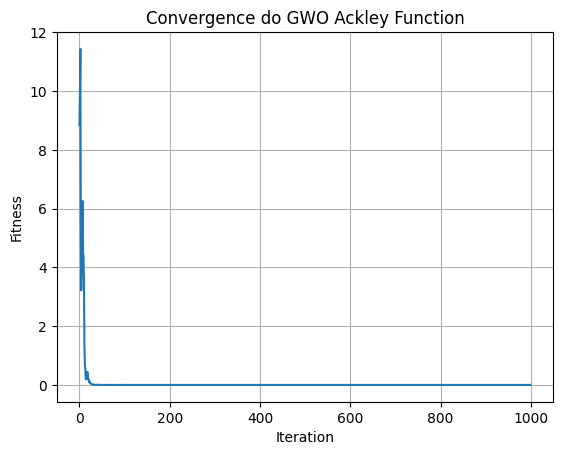

In [67]:
## Ackley test
dim = 2
bounds = (-32.768, 32.768)
n_wolves=30
max_iter=1000
best_position, best_value, history = gwo(ackley, dim, bounds, n_wolves, max_iter)
# Resultados
print(f"melhor posição encontrada: {best_position}")
print(f"melhor valor (fitness): {best_value}")

# Plot da convergência
plt.plot(history)
plt.title("Convergence do GWO Ackley Function")
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.grid()
plt.show()


melhor posição encontrada: [ 3.56624770e-92  3.25677631e-92  3.48399300e-92  3.43938221e-92
 -3.41499220e-92]
melhor valor (fitness): 5.895444352506027e-183


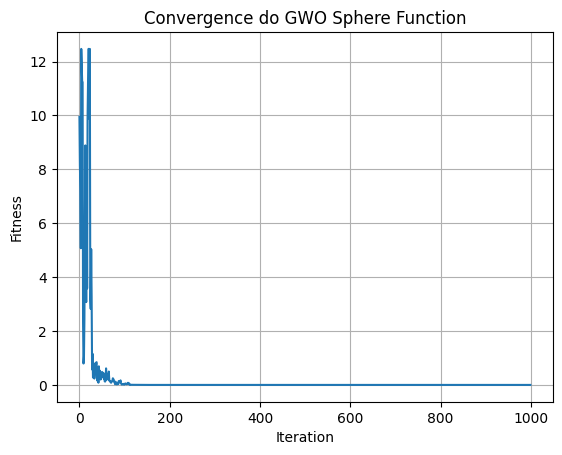

In [68]:
# Sphere Test
dim = 5
bounds = (-5.12, 5.12)
n_wolves=30
max_iter=1000
best_position, best_value, history = gwo(sphere, dim, bounds, n_wolves, max_iter)
# Resultados
print(f"melhor posição encontrada: {best_position}")
print(f"melhor valor (fitness): {best_value}")

# Plot da convergência
plt.plot(history)
plt.title("Convergence do GWO Sphere Function")
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.grid()
plt.show()


melhor posição encontrada: [0.95432344 0.91089177 0.82981031]
melhor valor (fitness): 0.010029885648279217


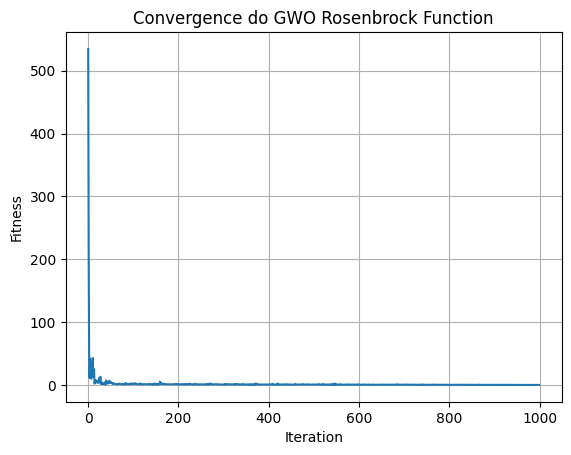

In [69]:
# rosen Test
dim = 3
bounds = (-5, 10)
n_wolves=50
max_iter=1000
best_position, best_value, history = gwo(rosen, dim, bounds, n_wolves, max_iter)
# Resultados
print(f"melhor posição encontrada: {best_position}")
print(f"melhor valor (fitness): {best_value}")

# Plot da convergência
plt.plot(history)
plt.title("Convergence do GWO Rosenbrock Function")
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.grid()
plt.show()


### Referências:
- Mirjalili, S. et al. (2014). Grey Wolf Optimizer. *Adv ances in Engineering Software*, 69, 46–61. https://doi.org/10.1016/j.advengsoft.2013.12.007
